In [1]:
%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import freud
import rowan

In [4]:
#filename = "/media/matt/SCRATCH/ActiveMatterWorms/data_02_02_2024/filament_data.npz"

filename = "/media/matt/DATA/data_22_05_2024/filament_data.npz"
#filename = "/media/matt/DATA/osc_data/data_15_05_2024-2/filament_data.npz"
data = np.load(filename)
pos_data = data['a']
vel_data = data['b']
print(vel_data.shape)
N = data['a'].shape[1]
nframes = data['a'].shape[0]
print(N)
print(nframes)

(501, 144000, 3)
144000
501


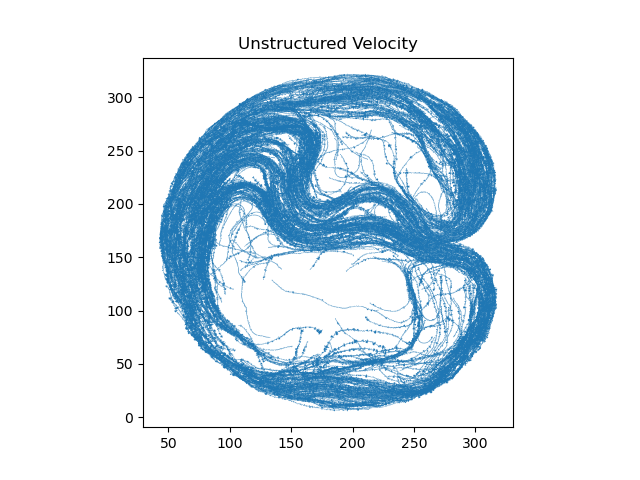

In [5]:
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(pos_data[-1,:,0], #x
                   pos_data[-1,:,1], #y
                   vel_data[-1,:,0], #u
                   vel_data[-1,:,1], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Velocity")
plt.show()

In [9]:
def get_vector_frame(iframe,worm_length,pos_data):
    #worm_length = 80
    #iframe = -1
    num_worms = int(N/worm_length)
    print("num_worms:",num_worms)
    vector_field = np.zeros((N,6))
    worm_view = np.array_split(pos_data[iframe,:,:],num_worms)
    count = 0
    for iw in range(num_worms):
        for ip in range(len(worm_view[iw])):
            ip1 = ip + 1
            if ip == len(worm_view[iw])-1:
                ip1 = ip-1
            vec = np.zeros(3)
            pos = np.zeros(3)
            pos[0] = worm_view[iw][ip][0]
            pos[1] = worm_view[iw][ip][1]
            pos[2] = worm_view[iw][ip][2]
            vec[0] = worm_view[iw][ip][0] - worm_view[iw][ip1][0] #X
            vec[1] = worm_view[iw][ip][1] - worm_view[iw][ip1][1] #Y
            vec[2] = worm_view[iw][ip][2] - worm_view[iw][ip1][2] #Z
            n = np.sqrt(vec[0] ** 2 + vec[1] ** 2 + vec[2]**2)
            vec = vec/n
            vector_field[count,0:3] = pos
            vector_field[count,3:6] = vec
            count += 1
    return vector_field
    
def get_Q(vector_field,num_interpolation_points):
    max_x = np.max(vector_field[:,0])
    min_x = np.min(vector_field[:,0])
    max_y = np.max(vector_field[:,1])
    min_y = np.min(vector_field[:,1])
    print("X:",min_x,max_x,max_x-min_x)
    print("Y:",min_y,max_y,max_y-min_y)

    x_grid,y_grid = np.meshgrid(np.linspace(min_x,max_x,num_interpolation_points),
                                np.linspace(min_y,max_y,num_interpolation_points))

    Qxx = np.zeros((num_interpolation_points,num_interpolation_points))
    Qxy = np.zeros((num_interpolation_points,num_interpolation_points))
    for i in np.arange(0,x_grid.shape[0]-1):
        for j in np.arange(0,y_grid.shape[1]-1):
            # getting the cell boundary points
            mask = (vector_field[:,0] >= x_grid[i,j]) & (vector_field[:,0] < x_grid[i,j+1]) & \
                 (vector_field[:,1] >= y_grid[i,j]) & (vector_field[:,1] < y_grid[i+1,j])
            # selecting particles that are in that cell
            if np.any(mask):
                x_cell_vals = vector_field[mask,3]
                y_cell_vals = vector_field[mask,4]
            else:
                x_cell_vals = 0.0
                y_cell_vals = 0.0

            Qxx[i,j] = 0.5*(3*np.mean(x_cell_vals*x_cell_vals)-1)
            Qxy[i,j] = 0.5*(3*np.mean(x_cell_vals*y_cell_vals))
    np.nan_to_num(Qxx, copy=False, nan=0.0)
    np.nan_to_num(Qxy, copy=False, nan=0.0)
    return Qxx,Qxy,x_grid,y_grid

def get_director(Qxx,Qxy,x_grid,y_grid,num_interpolation_points):
    nx = np.zeros((num_interpolation_points,num_interpolation_points))
    ny = np.zeros((num_interpolation_points,num_interpolation_points))
    for i in np.arange(0,x_grid.shape[0]-1):
        for j in np.arange(0,y_grid.shape[1]-1):
            #S[x,y] = 0.5*np.sqrt(self.trace_Q_squared(self.Q[x,y,0],self.Q[x,y,1]))
            a = Qxx[i,j]
            b = Qxy[i,j]
            eigenvalues,eigenvectors = np.linalg.eig(np.array([[a,b],[b,-a]]))
            nx[i,j] = eigenvectors[0,np.argmax(eigenvalues)]
            ny[i,j] = eigenvectors[1,np.argmax(eigenvalues)]
    return nx,ny

def calc_defects(Qxx,Qxy,x_grid,y_grid,normalize=True):
    dx = x_grid[0,1] - x_grid[0,0]
    dy = y_grid[1,0] - y_grid[0,0]

    dq11_tensor_dx = np.zeros_like(x_grid)
    dq12_tensor_dx = np.zeros_like(x_grid)
    dq11_tensor_dy = np.zeros_like(y_grid)
    dq12_tensor_dy = np.zeros_like(y_grid)

    dq11_tensor_dx[:, 1:-1] = (Qxx[:, 2:] - Qxx[:, :-2]) / (2 * dx)
    dq11_tensor_dx[:, 0] = (Qxx[:, 1] - Qxx[:, 0]) / dx
    dq11_tensor_dx[:, -1] = (Qxx[:, -1] - Qxx[:, -2]) / dx

    dq12_tensor_dx[:, 1:-1] = (Qxy[:, 2:] - Qxy[:, :-2]) / (2 * dx)
    dq12_tensor_dx[:, 0] = (Qxy[:, 1] - Qxy[:, 0]) / dx
    dq12_tensor_dx[:, -1] = (Qxy[:, -1] - Qxy[:, -2]) / dx

    dq11_tensor_dy[1:-1, :] = (Qxx[2:, :] - Qxx[:-2, :]) / (2 * dy)
    dq11_tensor_dy[0, :] = (Qxx[1, :] - Qxx[0, :]) / dy
    dq11_tensor_dy[-1, :] = (Qxx[-1, :] - Qxx[-2, :]) / dy

    dq12_tensor_dy[1:-1, :] = (Qxy[2:, :] - Qxy[:-2, :]) / (2 * dy)
    dq12_tensor_dy[0, :] = (Qxy[1, :] - Qxy[0, :]) / dy
    dq12_tensor_dy[-1, :] = (Qxy[-1, :] - Qxy[-2, :]) / dy

    dij = dq11_tensor_dx * dq12_tensor_dy - dq11_tensor_dy*dq12_tensor_dx
    print(dij.shape)
    #normalizing dij
    if normalize:
        dij = (dij-np.min(dij))/(np.max(dij)-np.min(dij)) #nomalizes between 0 and 1
        dij[(dij > 0.25) & (dij < 0.75)] = 0.5
        dij = dij- 0.5
    return dij

In [11]:
worm_length = 120
unstructured_vec = get_vector_frame(-1,worm_length,pos_data)
# num_interpolation_points = 40
# Qxx,Qxy,x_grid,y_grid = get_Q(vector_field,num_interpolation_points)
# nx,ny = get_director(Qxx,Qxy,x_grid,y_grid,num_interpolation_points)
print(unstructured_vec.shape)

num_worms: 1200
(144000, 6)


In [16]:
orientations = unstructured_vec[:,3:6]
print(orientations.shape)
nematic = freud.order.Nematic()
nematic.compute(orientations)
print(nematic.order)

(144000, 3)
0.30433720350265503


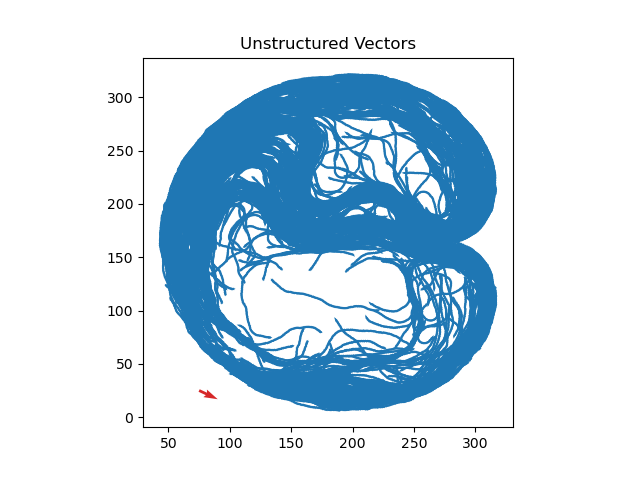

In [21]:
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(unstructured_vec[:,0], #x
                   unstructured_vec[:,1], #y
                   unstructured_vec[:,3], #u
                   unstructured_vec[:,4], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
nem_arrow = ax.quiver(75,25,
    nematic.director[0],
    nematic.director[1],
    color="tab:red",
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Vectors w/ Freud Vector")
plt.show()